# Image features exercise
*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

We have seen that we can achieve reasonable performance on an image classification task by training a linear classifier on the pixels of the input image. In this exercise we will show that we can improve our classification performance by training linear classifiers not on raw pixels but on features that are computed from the raw pixels.

All of your work for this exercise will be done in this notebook.

In [1]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Load data
Similar to previous exercises, we will load CIFAR-10 data from disk.

In [2]:
from cs231n.features import color_histogram_hsv, hog_feature

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()

## Extract Features
For each image we will compute a Histogram of Oriented
Gradients (HOG) as well as a color histogram using the hue channel in HSV
color space. We form our final feature vector for each image by concatenating
the HOG and color histogram feature vectors.

Roughly speaking, HOG should capture the texture of the image while ignoring
color information, and the color histogram represents the color of the input
image while ignoring texture. As a result, we expect that using both together
ought to work better than using either alone. Verifying this assumption would
be a good thing to try for your interests.

The `hog_feature` and `color_histogram_hsv` functions both operate on a single
image and return a feature vector for that image. The extract_features
function takes a set of images and a list of feature functions and evaluates
each feature function on each image, storing the results in a matrix where
each column is the concatenation of all feature vectors for a single image.

In [3]:
from cs231n.features import *

num_color_bins = 10 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

## Train SVM on features
Using the multiclass SVM code developed earlier in the assignment, train SVMs on top of the features extracted above; this should achieve better results than training SVMs directly on top of raw pixels.

In [4]:
# Use the validation set to tune the learning rate and regularization strength

from cs231n.classifiers.linear_classifier import LinearSVM

learning_rates = [1e-9, 1e-8, 1e-7]
regularization_strengths = [5e4, 5e5, 5e6]

results = {}
best_val = -1
best_svm = None

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained classifer in best_svm. You might also want to play          #
# with different numbers of bins in the color histogram. If you are careful    #
# you should be able to get accuracy of near 0.44 on the validation set.       #
################################################################################
for lr in learning_rates:
    for reg in regularization_strengths:
        svm = LinearSVM()
        loss_hist = svm.train(X_train_feats, y_train, learning_rate = lr, reg = reg, num_iters=1500, verbose=True)
        y_train_pred = svm.predict(X_train_feats)
        train_acc = np.mean(y_train == y_train_pred)
        y_val_pred = svm.predict(X_val_feats)
        val_acc = np.mean(y_val == y_val_pred)
        results[(lr, reg)] = (train_acc, val_acc)
        if val_acc > best_val:
            best_val = val_acc
            best_svm = svm
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

iteration 0 / 1500: loss 46.518463
iteration 100 / 1500: loss 46.148362
iteration 200 / 1500: loss 45.783022
iteration 300 / 1500: loss 45.411573
iteration 400 / 1500: loss 45.051595
iteration 500 / 1500: loss 44.704613
iteration 600 / 1500: loss 44.337851
iteration 700 / 1500: loss 43.993178
iteration 800 / 1500: loss 43.640369
iteration 900 / 1500: loss 43.299645
iteration 1000 / 1500: loss 42.955159
iteration 1100 / 1500: loss 42.618510
iteration 1200 / 1500: loss 42.280421
iteration 1300 / 1500: loss 41.954850
iteration 1400 / 1500: loss 41.616886
iteration 0 / 1500: loss 393.912317
iteration 100 / 1500: loss 357.282232
iteration 200 / 1500: loss 324.124308
iteration 300 / 1500: loss 294.127743
iteration 400 / 1500: loss 266.973485
iteration 500 / 1500: loss 242.421714
iteration 600 / 1500: loss 220.218427
iteration 700 / 1500: loss 200.111347
iteration 800 / 1500: loss 181.911576
iteration 900 / 1500: loss 165.458055
iteration 1000 / 1500: loss 150.559360
iteration 1100 / 1500: lo

In [5]:
# Evaluate your trained SVM on the test set
y_test_pred = best_svm.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print(test_accuracy)

0.413


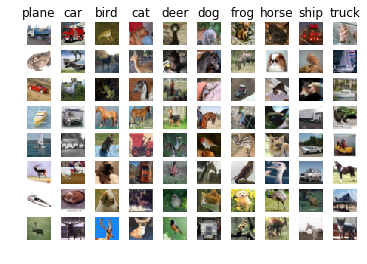

In [6]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

### Inline question 1:
Describe the misclassification results that you see. Do they make sense?

## Neural Network on image features
Earlier in this assigment we saw that training a two-layer neural network on raw pixels achieved better classification performance than linear classifiers on raw pixels. In this notebook we have seen that linear classifiers on image features outperform linear classifiers on raw pixels. 

For completeness, we should also try training a neural network on image features. This approach should outperform all previous approaches: you should easily be able to achieve over 55% classification accuracy on the test set; our best model achieves about 60% classification accuracy.

In [8]:
# Preprocessing: Remove the bias dimension
# Make sure to run this cell only ONCE
print(X_train_feats.shape)
X_train_feats = X_train_feats[:, :-1]
X_val_feats = X_val_feats[:, :-1]
X_test_feats = X_test_feats[:, :-1]

print(X_train_feats.shape)

(49000, 154)
(49000, 153)


In [12]:
from cs231n.classifiers.neural_net import TwoLayerNet

input_dim = X_train_feats.shape[1]
hidden_dim = 500
num_classes = 10

net = TwoLayerNet(input_dim, hidden_dim, num_classes)
best_net = None

################################################################################
# TODO: Train a two-layer neural network on image features. You may want to    #
# cross-validate various parameters as in previous sections. Store your best   #
# model in the best_net variable.                                              #
################################################################################
best_acc = 0.0
for reg in [1e-2, 1e-1, 0.5, 1]:
    for bs in [200, 400]:
        for lr in [1e-3, 1e-2, 1e-1, 0.5, 1, 1.5, 2]:
            net = TwoLayerNet(input_dim, hidden_dim, num_classes)
            # Train the network
            stats = net.train(X_train_feats, y_train, X_val_feats, y_val,
                        num_iters=1000, batch_size=bs,
                        learning_rate=lr, learning_rate_decay=0.95,
                        reg=reg, verbose=True)

            # Predict on the validation set
            val_acc = (net.predict(X_val_feats) == y_val).mean()
            print('reg: ', reg, 'bs: ', bs, 'lr: ', lr, 'Validation accuracy: ', val_acc)
            if val_acc > best_acc:
                best_acc = val_acc
                best_net = net
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

iteration 0 / 1000: loss 2.302589
iteration 100 / 1000: loss 2.302601
iteration 200 / 1000: loss 2.302605
iteration 300 / 1000: loss 2.302576
iteration 400 / 1000: loss 2.302595
iteration 500 / 1000: loss 2.302593
iteration 600 / 1000: loss 2.302599
iteration 700 / 1000: loss 2.302497
iteration 800 / 1000: loss 2.302559
iteration 900 / 1000: loss 2.302633
reg:  0.01 bs:  200 lr:  0.001 Validation accuracy:  0.105
iteration 0 / 1000: loss 2.302589
iteration 100 / 1000: loss 2.302676
iteration 200 / 1000: loss 2.302785
iteration 300 / 1000: loss 2.302375
iteration 400 / 1000: loss 2.302911
iteration 500 / 1000: loss 2.302579
iteration 600 / 1000: loss 2.302365
iteration 700 / 1000: loss 2.302481
iteration 800 / 1000: loss 2.302507
iteration 900 / 1000: loss 2.302539
reg:  0.01 bs:  200 lr:  0.01 Validation accuracy:  0.152
iteration 0 / 1000: loss 2.302589
iteration 100 / 1000: loss 2.302898
iteration 200 / 1000: loss 2.168741
iteration 300 / 1000: loss 1.889364
iteration 400 / 1000: los

iteration 900 / 1000: loss 2.043184
reg:  0.1 bs:  200 lr:  1.5 Validation accuracy:  0.383
iteration 0 / 1000: loss 2.302626
iteration 100 / 1000: loss 2.189286
iteration 200 / 1000: loss 2.297387
iteration 300 / 1000: loss 2.228791
iteration 400 / 1000: loss 2.126750
iteration 500 / 1000: loss 2.025797
iteration 600 / 1000: loss 2.077974
iteration 700 / 1000: loss 2.237776
iteration 800 / 1000: loss 2.114133
iteration 900 / 1000: loss 2.148433
reg:  0.1 bs:  200 lr:  2 Validation accuracy:  0.339
iteration 0 / 1000: loss 2.302626
iteration 100 / 1000: loss 2.302620
iteration 200 / 1000: loss 2.302616
iteration 300 / 1000: loss 2.302625
iteration 400 / 1000: loss 2.302637
iteration 500 / 1000: loss 2.302634
iteration 600 / 1000: loss 2.302606
iteration 700 / 1000: loss 2.302629
iteration 800 / 1000: loss 2.302588
iteration 900 / 1000: loss 2.302609
reg:  0.1 bs:  400 lr:  0.001 Validation accuracy:  0.078
iteration 0 / 1000: loss 2.302626
iteration 100 / 1000: loss 2.302722
iteration 

iteration 700 / 1000: loss 2.304102
iteration 800 / 1000: loss 2.303681
iteration 900 / 1000: loss 2.302263
reg:  0.5 bs:  400 lr:  1 Validation accuracy:  0.153
iteration 0 / 1000: loss 2.302788
iteration 100 / 1000: loss 2.303386
iteration 200 / 1000: loss 2.304254
iteration 300 / 1000: loss 2.305426
iteration 400 / 1000: loss 2.303924
iteration 500 / 1000: loss 2.299642
iteration 600 / 1000: loss 2.305786
iteration 700 / 1000: loss 2.304567
iteration 800 / 1000: loss 2.304290
iteration 900 / 1000: loss 2.308753
reg:  0.5 bs:  400 lr:  1.5 Validation accuracy:  0.195
iteration 0 / 1000: loss 2.302789
iteration 100 / 1000: loss 2.302169
iteration 200 / 1000: loss 2.305418
iteration 300 / 1000: loss 2.304737
iteration 400 / 1000: loss 2.301908
iteration 500 / 1000: loss 2.300839
iteration 600 / 1000: loss 2.301484
iteration 700 / 1000: loss 2.305188
iteration 800 / 1000: loss 2.303976
iteration 900 / 1000: loss 2.310685
reg:  0.5 bs:  400 lr:  2 Validation accuracy:  0.095
iteration 0 

C:\Users\X1\Anaconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)
C:\Users\X1\Documents\cs231n\assignment1\cs231n\classifiers\neural_net.py:96: RuntimeWarning: overflow encountered in subtract
  f = scores - np.max(scores, axis = 1, keepdims = True)
C:\Users\X1\Documents\cs231n\assignment1\cs231n\classifiers\neural_net.py:96: RuntimeWarning: invalid value encountered in subtract
  f = scores - np.max(scores, axis = 1, keepdims = True)
C:\Users\X1\Documents\cs231n\assignment1\cs231n\classifiers\neural_net.py:98: RuntimeWarning: overflow encountered in double_scalars
  loss = loss / N + 0.5 * reg * (np.sum(W1 * W1) + np.sum(W2 * W2))
C:\Users\X1\Documents\cs231n\assignment1\cs231n\classifiers\neural_net.py:78: RuntimeWarning: invalid value encountered in maximum
  hidden_layer = np.maximum(0, X.dot(W1) + b1)
C:\Users\X1\Anaconda3\lib\site-packages\numpy\core\_methods.py:26: RuntimeWarning: inv

iteration 500 / 1000: loss nan
iteration 600 / 1000: loss nan
iteration 700 / 1000: loss nan
iteration 800 / 1000: loss nan
iteration 900 / 1000: loss nan
reg:  1 bs:  200 lr:  2 Validation accuracy:  0.087
iteration 0 / 1000: loss 2.302992
iteration 100 / 1000: loss 2.302909
iteration 200 / 1000: loss 2.302880
iteration 300 / 1000: loss 2.302812
iteration 400 / 1000: loss 2.302775
iteration 500 / 1000: loss 2.302766
iteration 600 / 1000: loss 2.302725
iteration 700 / 1000: loss 2.302696
iteration 800 / 1000: loss 2.302670
iteration 900 / 1000: loss 2.302624
reg:  1 bs:  400 lr:  0.001 Validation accuracy:  0.079
iteration 0 / 1000: loss 2.302994
iteration 100 / 1000: loss 2.302606
iteration 200 / 1000: loss 2.302571
iteration 300 / 1000: loss 2.302605
iteration 400 / 1000: loss 2.302794
iteration 500 / 1000: loss 2.302674
iteration 600 / 1000: loss 2.302802
iteration 700 / 1000: loss 2.302438
iteration 800 / 1000: loss 2.302730
iteration 900 / 1000: loss 2.302506
reg:  1 bs:  400 lr: 

In [13]:
# Run your best neural net classifier on the test set. You should be able
# to get more than 55% accuracy.

test_acc = (best_net.predict(X_test_feats) == y_test).mean()
print(test_acc)

0.528
